# Import Modules

In [22]:
import os
import sys
import numpy as np
import math
import xarray as xr
import pandas as pd
import wrf
from matplotlib import pyplot as plt
from matplotlib import gridspec
import json
plt.style.use('seaborn-white')

# Load NetCDF From Cluster

In [72]:
scratch_folder_loc = '/p/lustre2/nainap/'
#netCDF_file_loc = os.path.join(scratch_folder_loc,'From_Pankaj', 'NetCDF_files','wrfout_chisholmView' )
netCDF_file_loc = os.path.join(scratch_folder_loc,'From_Pankaj', 'NetCDF_files','wrfout_GAD_FINO_SecondResult' )

In [24]:
netCDF_file_loc = '/p/lustre2/jha3/fromWill/FINO_MesoMicro_GAD_NO_CPM/part5_output/tsout_d06_2010-05-16_00:00:10'

In [25]:
netCDF_file_loc

'/p/lustre2/jha3/fromWill/FINO_MesoMicro_GAD_NO_CPM/part5_output/tsout_d06_2010-05-16_00:00:10'

In [26]:
wrf_domain6 = xr.open_dataset(netCDF_file_loc)

In [27]:
wrf_domain6['UTS']

<xarray.DataArray 'UTS' (Time: 60, bottom_top: 108, south_north: 600, west_east: 600)>
[2332800000 values with dtype=float32]
Coordinates:
    XLAT     (Time, south_north, west_east) float32 ...
    XLONG    (Time, south_north, west_east) float32 ...
Dimensions without coordinates: Time, bottom_top, south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XYZ
    description:  u (x) velocity at mass points
    units:        m s-1
    stagger:      
    coordinates:  XLONG XLAT XTIME

# Set-Up Variables for Contour Plots

In [28]:
qoi = 'UTS' #input('Choose the variable to be plotted\n')
phi = wrf_domain6[qoi]

qoi_dim = phi.shape

#shape format in : [time, z, y, x]
[time_dim, bottom_top_dim, south_north_dim, west_east_dim] = qoi_dim 
print(qoi_dim)

plane_header = wrf_domain6[qoi].dims
print(plane_header)

(60, 108, 600, 600)
('Time', 'bottom_top', 'south_north', 'west_east')


### Provide desired time and location for contour plots

In [68]:
#default
#desired_time = [0,time_dim-1]
desired_time = list(np.linspace(0, time_dim-1, time_dim).astype(int))
#hub_height = int(wrf_domain6['HUB_HEIGHT'].isel(Time=0)[0])
hub_height = 100
#bottom_top = [0.05*hub_height, 0.1*hub_height, 0.5*hub_height,hub_height] #bottom_top_locs
bottom_top = [15,20,25]
south_north = [int(west_east_dim*0.5), int(west_east_dim*0.75)] #south_north_locs
west_east = [int(bottom_top_dim*0.25), int(south_north_dim*0.5), int(south_north_dim*0.75)] #west_east_locs

#sampling location dictionary
sampling_loc_time = '{"%s" : %s, "%s" : %s, "%s" : %s, "%s" : %s}'%('Time',desired_time,plane_header[1],bottom_top,plane_header[2],south_north, plane_header[3],west_east)
slt = json.loads(sampling_loc_time)

In [66]:
#list(np.linspace(0, time_dim, time_dim +1).astype(int))

In [69]:
slt

{'Time': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59],
 'bottom_top': [15, 20, 25],
 'south_north': [300, 450],
 'west_east': [27, 300, 450]}

### Plot Contours

In [70]:
def contourPlot(string, slt, plane_rows, plane_cols, pl):
    desired_time = slt['Time']
    desired_space = slt[string]
    qoi_time = [[]]
    for k in range(0,np.size(desired_time)):
        qoi_space = []
        for j in range(0,np.size(desired_space)):
            slice_loc = '{"%s" : %d}'%(string, desired_space[j])
            slice_loc_dict = json.loads(slice_loc)
            arr = phi.isel(Time=desired_time[k]).isel(slice_loc_dict)
            axes_name = arr.dims
            qoi_space.append(np.array(arr))
                    
        qoi_time.append(qoi_space)
       
    #print('qoi_time ', qoi_time)
    ncols = np.size(desired_space)    
    nrows = np.size(desired_time)
        
    cmap_name = 'rainbow'
     
    if nrows==1:
        fig = plt.figure(figsize = (20, 4))
        fig.subplots_adjust(hspace=0.2, wspace=0.25)
        #fig.figure(figsize = (20, 4))
        for i in range(ncols):
            time_inst_space = qoi_time[1]
            space = time_inst_space[i]
            x = int(round(np.shape(space)[0],-2))
            y = int(round(np.shape(space)[1],-2))
            ratio = y/x
            #print(ratio)
            ax = fig.add_subplot(nrows, ncols, i+1)
            fig.set_figheight(4*nrows)
            fig.set_figwidth(5*ncols*ratio)
            cont = ax.contourf(plane_cols,plane_rows, space, 20, cmap=cmap_name)
            clb = fig.colorbar(cont, ax=ax)
            clb.ax.set_title(f"%s [m/s]"%qoi, weight='bold')
            ax.set_xlabel(axes_name[1], fontsize=14)
            ax.set_ylabel(axes_name[0], fontsize=14)
            ax.tick_params(axis='x', labelsize=14)
            ax.tick_params(axis='y', labelsize=14)
            ax.set_title(f"%s=%d" %(string,desired_space[i]), fontsize=16)
        fig.tight_layout()
    else:
        fig, ax = plt.subplots(nrows, ncols, figsize = (20,4.5), sharex='col', sharey='row')#figsize = (20,4.5)
        fig.subplots_adjust(hspace=0.5, wspace=0.1)
    
        for l in range(nrows):
            time_inst_space = qoi_time[l+1]
            #ax.annotate(desired_time[l], textcoords='offset points',
                #size='large', ha='right', va='center')
            for m in range(ncols):
                space = time_inst_space[m]
                x = int(round(np.shape(space)[0],-2))
                y = int(round(np.shape(space)[1],-2))
                ratio = y/x
                #print(ratio)
                cont = ax[l,m].contourf(plane_cols,plane_rows, space, 20, cmap=cmap_name)
                clb = fig.colorbar(cont, ax=ax[l,m])
                clb.ax.set_title(f"%s [m/s]"%qoi, weight='bold')
                fig.set_figheight(4.5*nrows)#figsize = (4.5*nrows)
                fig.set_figwidth(5*ncols*ratio)
                ax[l,m].set_xlabel(axes_name[1], fontsize=14)
                ax[l,m].set_ylabel(axes_name[0], fontsize=14)
                ax[l,m].tick_params(axis='x', labelsize=14)
                ax[l,m].tick_params(axis='y', labelsize=14)
                ax[l,m].set_title(f"%s=%d" %(string,desired_space[m]), fontsize=16)
                ax[l,m].set_xlim([250,350])
                ax[l,m].set_ylim([250,350])
        fig.tight_layout()
    
    filename = "%s-plane"%pl
    plt.savefig(filename, bbox_inches='tight')       
            

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


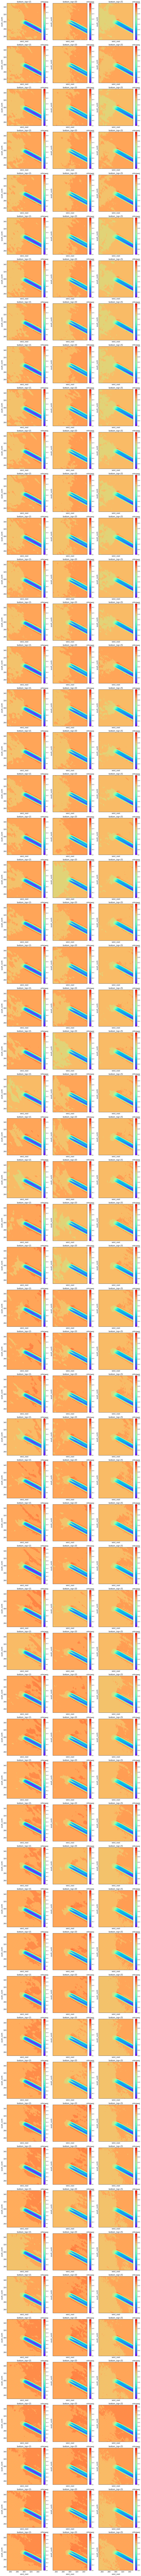

In [71]:
plane = ['xy','yz','xz']

for i in range(0,1):
    pl = plane[i]
    if pl=='xy':
        plane_cols, plane_rows = np.meshgrid(wrf_domain6[plane_header[3]], wrf_domain6[plane_header[2]])
        contourPlot(plane_header[1],slt,plane_rows, plane_cols, pl)
    elif pl=='yz':
        plane_cols, plane_rows = np.meshgrid(wrf_domain6[plane_header[2]], wrf_domain6[plane_header[1]])
        contourPlot(plane_header[3],slt,plane_rows, plane_cols, pl)
    elif pl=='xz':
        plane_cols, plane_rows = np.meshgrid(wrf_domain6[plane_header[3]], wrf_domain6[plane_header[1]])
        contourPlot(plane_header[2],slt,plane_rows, plane_cols, pl)

# Set-Up Line Plots

In [33]:
#True height
true_height = (wrf_domain6['PH']+wrf_domain6['PHB'])/9.81

KeyError: 'PH'

In [ ]:
print(true_height.isel(Time=0).isel(south_north=300).isel(west_east=300))

In [ ]:
# Properties varying with height
qois = ['U', 'V', 'T', 'P']
units = ['m/s', 'm/s', 'K', 'Pa']

#south_north location 
south_north_loc = 300
#west_east location
west_east_loc = 300
#time instance 
t = time_dim-1

fig = plt.figure(figsize = (8,10))
fig.subplots_adjust(hspace=0.2, wspace=1)

for k in range (0,np.size(qois)):
    dimensions = wrf_domain6[qois[k]].dims
    sn_loc = '{"%s" : %d}'%(dimensions[2], south_north_loc)
    sn_loc_dict = json.loads(sn_loc)
    we_loc = '{"%s" : %d}'%(dimensions[3], west_east_loc)
    we_loc_dict = json.loads(we_loc)
    qoi_loc = wrf_domain6[qois[k]].isel(Time=t).isel(sn_loc_dict).isel(we_loc_dict)
    height = true_height.isel(Time=t).isel(south_north=south_north_loc).isel(west_east = west_east_loc)
    h = wrf.destagger(height,0)
    ax = fig.add_subplot(2, 2, k+1)
    ax.plot(qoi_loc, h)
    ax.grid()
    ax.set_xlabel(f"%s [%s]"%(qois[k], units[k]), fontsize=14, weight='bold')
    ax.set_ylabel('Height [m]', fontsize=14, weight='bold')
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)   



In [ ]:
'''
print(np.array(wrf_domain6['XTIME']))
print(wrf_domain6['X_TURBINE'])
print(wrf_domain6['XLAT'])
print(wrf_domain6['HUB_HEIGHT'])
print(wrf_domain6['V0_TIME_SERIES'])
print(wrf_domain6['D0_TIME_SERIES'])
print(wrf_domain6['HUB_HEIGHT'].isel(Time=0)[1])
'''

In [ ]:
# Time series plots

date_time = np.array(wrf_domain6['XTIME'])
wind_speed = np.array(wrf_domain6['V0_TIME_SERIES'].isel(ntmeturb=200))
wind_dir = np.array(wrf_domain6['D0_TIME_SERIES'].isel(ntmeturb=200))
power = np.array(wrf_domain6['POWER'].isel(nturbines=0))
#power = np.array(wrf_domain6['WP_POWER'].isel(nurbines=20))
#torque = np.array(wrf_domain6['WP_TORQUE'].isel(nurbines=20))

time_series = {
    'DATE': date_time,
    'Wind_Speed' : wind_speed,
    'Wind_Direction' : wind_dir,
    'Power' : power/1000
}

dataframe = pd.DataFrame(time_series,columns=['DATE', 'Wind_Speed', 'Wind_Direction', 'Power'])
dataframe["DATE"] = dataframe["DATE"].astype("datetime64")
dataframe = dataframe.set_index("DATE")

f, axs = plt.subplots(3,1, figsize = (12, 8) )
f.subplots_adjust(hspace=1, wspace=1)


plt.subplot(3,1, 1)
plt.plot(dataframe["Wind_Speed"], marker='o')
plt.grid()
plt.xlabel("Time", fontsize=14, weight='bold')
plt.ylabel("Wind Speed [m/s]", fontsize=14, weight='bold')
plt.title("Change in Wind Speed at Hub Height with Time", fontsize=16, weight='bold')

plt.subplot(3,1, 2)
plt.plot(dataframe["Wind_Direction"], marker='o')
plt.grid()
plt.xlabel("Time", fontsize=14, weight='bold')
plt.ylabel("Wind Direction [in deg.]", fontsize=14, weight='bold')
plt.title("Change in Wind Direction at Hub Height with Time", fontsize=16, weight='bold')

plt.subplot(3,1, 3)
plt.plot(dataframe["Power"], marker='o')
plt.grid()
plt.xlabel("Time", fontsize=14, weight='bold')
plt.ylabel("Power [kW]",fontsize=14, weight='bold')
plt.title("Change in Power at Turbine = 20 with Time", fontsize=16, weight='bold')



## Volume Rendering

In [ ]:
import plotly.graph_objects as go

print(wrf_domain6['U']['west_east_stag'])

fig= go.Figure(data=go.Isosurface(
    x=wrf_domain6['U']['west_east_stag'],
    y=wrf_domain6['U']['south_north'],
    z=wrf_domain6['U']['bottom_top'],
    value=[30],
    isomin=28,
    isomax=32,
))

fig.show()


In [ ]:
# Read data from a csv
z_data = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/api_docs/mt_bruno_elevation.csv')
print(type(z_data.values))
print(np.shape(z_data.values))

fig = go.Figure(data=[go.Surface(z=z_data.values)])

fig.update_layout(title='Mt Bruno Elevation', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

fig.show()

U = np.array(wrf_domain6['U'].isel(Time=5))
print(U)
print(np.shape(U))

In [ ]:
x = np.array(wrf_domain6[plane_header[2]])
y = np.array(wrf_domain6[plane_header[1]])
z = np.array(true_height['bottom_top_stag'])
U = np.array(wrf_domain6['U'])
V = np.array(wrf_domain6['V'])
W = np.array(wrf_domain6['W'])

print(W)
print(z)